In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime

In [3]:
df = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/medical/medical_time_series .csv')

In [4]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [5]:
#Check missing data
df.isnull().any()

Day        False
Revenue    False
dtype: bool

In [6]:
#Convert the Day values to match deates in 2015
def convert_to_date(x):
    return datetime.date(2015,1,1) + datetime.timedelta(days = x - 1)
df['Date'] = df['Day'].apply(convert_to_date)
df

,Day,Revenue,Date
0,1,0.000000,2015-01-01
1,2,-0.292356,2015-01-02
2,3,-0.327772,2015-01-03
3,4,-0.339987,2015-01-04
4,5,-0.124888,2015-01-05
...,...,...,...
726,727,15.722056,2016-12-27
727,728,15.865822,2016-12-28
728,729,15.708988,2016-12-29
729,730,15.822867,2016-12-30


In [7]:
df.set_index('Date', drop = True, inplace = True)
df

,Day,Revenue
Date,,
2015-01-01,1,0.000000
2015-01-02,2,-0.292356
2015-01-03,3,-0.327772
2015-01-04,4,-0.339987
2015-01-05,5,-0.124888
...,...,...
2016-12-27,727,15.722056
2016-12-28,728,15.865822
2016-12-29,729,15.708988


In [8]:
#Drop unnecessary column
df2 = df[['Revenue']]
df2

,Revenue
Date,
2015-01-01,0.000000
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
...,...
2016-12-27,15.722056
2016-12-28,15.865822
2016-12-29,15.708988


In [9]:
#Drop the first row to get rid of 0 Revenue value
df2 = df2[df2['Revenue'] != 0]
df2

,Revenue
Date,
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
2015-01-06,-0.491590
...,...
2016-12-27,15.722056
2016-12-28,15.865822
2016-12-29,15.708988


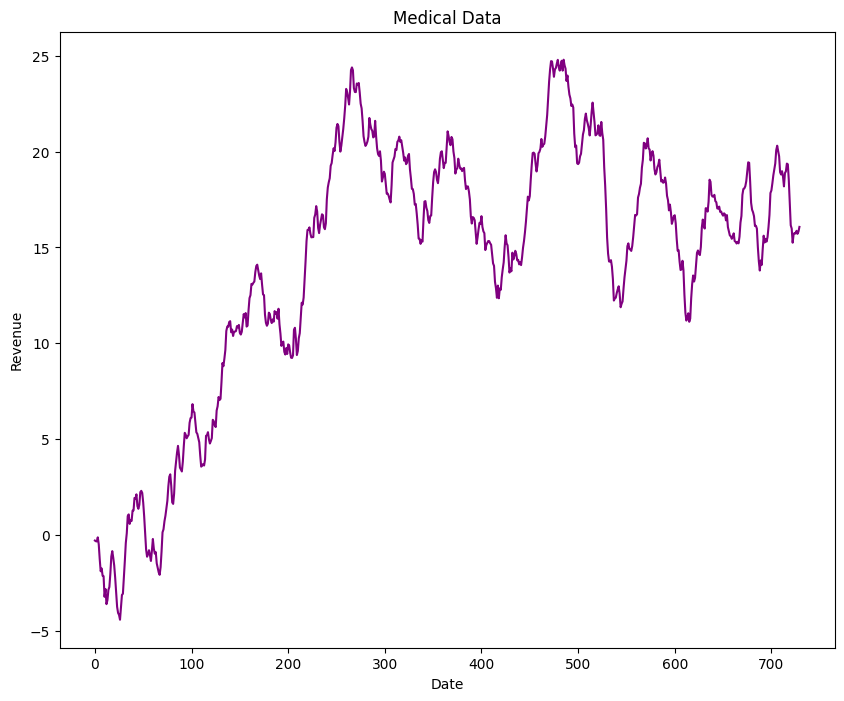

In [10]:
index = pd.Series(range(df2.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Medical Data')
plt.plot(index, df2.Revenue, color = 'purple')
plt.show()

In [11]:
#Use ADF to assess whether dataset is stationary or non-stationary 
df_test = ts.adfuller(df2['Revenue'], autolag = 'AIC')
df_op = pd.Series(df_test[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test[4].items():
    df_op['Critical Value (%s)'%key] = value
df_op

ADF Statistic            -2.210771
p-Value                   0.202360
Lags                      1.000000
Observations            728.000000
Critical Value (1%)      -3.439364
Critical Value (5%)      -2.865518
Critical Value (10%)     -2.568888
dtype: float64

In [12]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2015-01-02 to 2016-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB
None


In [13]:
df2.head()

,Revenue
Date,
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
2015-01-06,-0.491590


In [14]:
#Transform dataset to stationary by using differencing (subtracting each point from the previous value).
df_stationary = df2.diff(periods = 1, axis = 0).dropna()
print(df_stationary.info())
print(df_stationary.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 2015-01-03 to 2016-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  729 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB
None
(729, 1)


In [15]:
df_stationary.head()

,Revenue
Date,
2015-01-03,-0.035416
2015-01-04,-0.012215
2015-01-05,0.215100
2015-01-06,-0.366702
2015-01-07,-0.763660


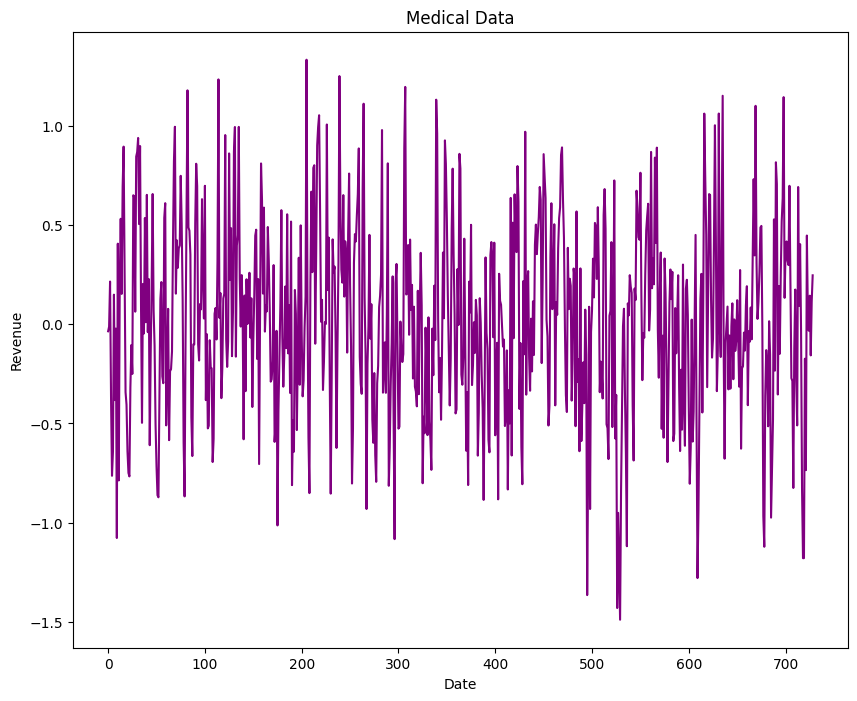

In [16]:
index2 = pd.Series(range(df_stationary.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Medical Data')
plt.plot(index2, df_stationary.Revenue, color = 'purple')
plt.show()

In [17]:
#Use ADF to reassess whether updated dataset is stationary or non-stationary 
df_test2 = ts.adfuller(df_stationary['Revenue'], autolag = 'AIC')
df_op2 = pd.Series(df_test2[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test2[4].items():
    df_op2['Critical Value (%s)'%key] = value
df_op2

ADF Statistic          -1.735420e+01
p-Value                 5.249586e-30
Lags                    0.000000e+00
Observations            7.280000e+02
Critical Value (1%)    -3.439364e+00
Critical Value (5%)    -2.865518e+00
Critical Value (10%)   -2.568888e+00
dtype: float64

In [18]:
#Create Training and Test, keeping the recommended 4:1 ratio
test_size = int(.20 * df_stationary.shape[0])
train, test = train_test_split(df_stationary, test_size = test_size, shuffle = False, random_state = 22)

In [19]:
acf = acf((train['Revenue'].values))
acf_df = pd.DataFrame([acf]).T
acf_df.columns = ['ACF']

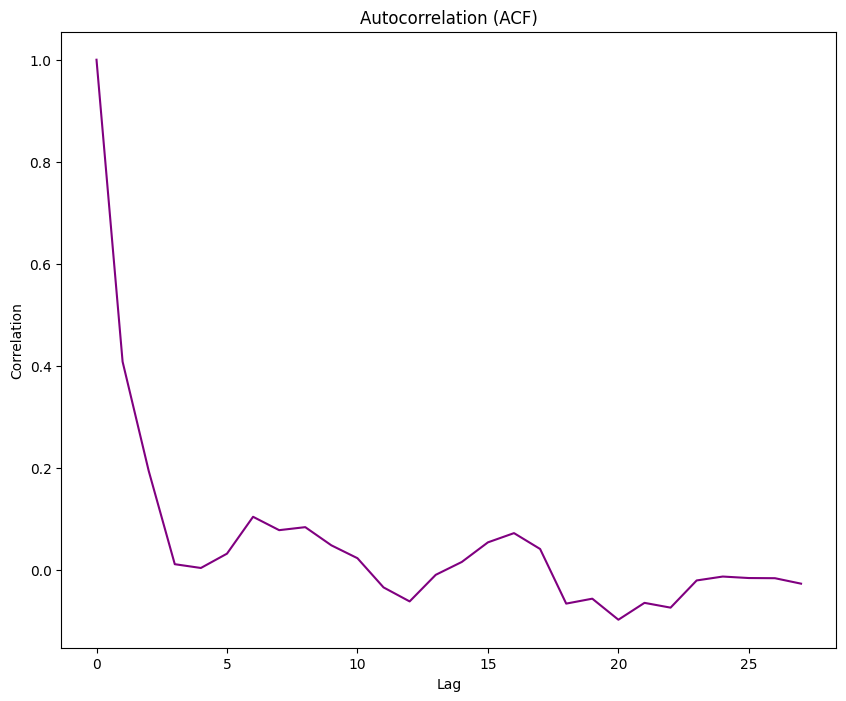

In [20]:
#ACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(acf_df.ACF, 'purple')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Autocorrelation (ACF)')
plt.show()

In [21]:
pacf = pacf((train['Revenue'].values))
pacf_df = pd.DataFrame([pacf]).T
pacf_df.columns = ['PACF']

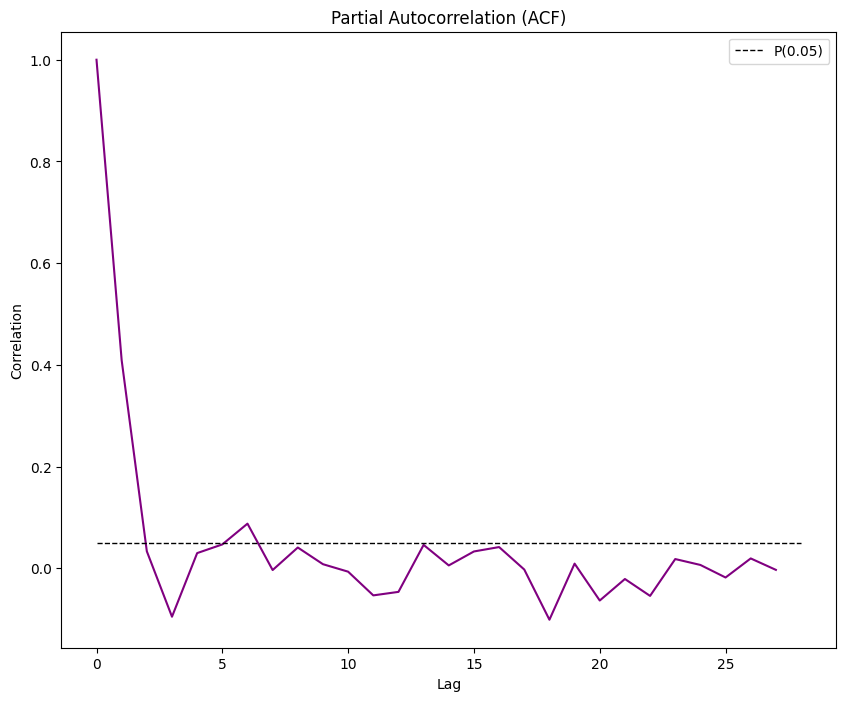

In [22]:
#PACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(pacf_df.PACF, 'purple')
ax.hlines(y = 0.05, xmin = 0, xmax = len(pacf), lw = 1, linestyles = '--', color = 'black', label = 'P(0.05)')
ax.legend()
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation (ACF)')
plt.show()

In [23]:
df2.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df2_cleaned.csv')

In [24]:
df_stationary.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df_stationary.csv')

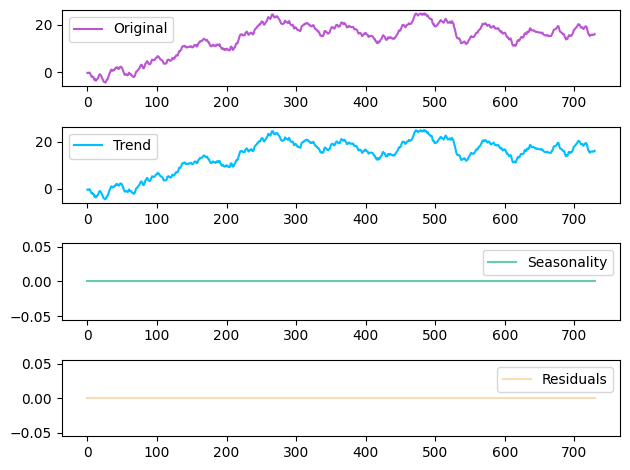

In [25]:
#Use seasonal_decompose to plot decomposition values
decomposition = seasonal_decompose(df2['Revenue'].values, model = 'additive', period = 1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(df2['Revenue'].values, label = 'Original', color = 'mediumorchid')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'deepskyblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'mediumaquamarine')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label = 'Residuals', color = 'wheat')
plt.legend(loc='best')
plt.tight_layout()

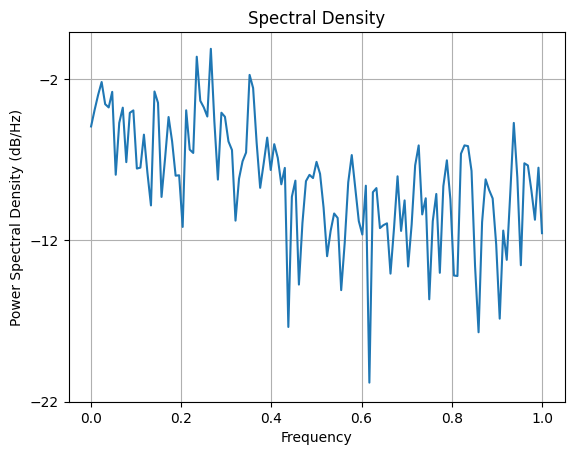

In [26]:
plt.psd(df_stationary['Revenue'])
plt.title('Spectral Density')
plt.show()

In [27]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [28]:
df_stationary.reset_index(inplace=True)
df_stationary = df_stationary.rename(columns = {'index':'Date'})

In [29]:
#Use auto_arima to cycle through potential models for best fit
auto_arima(train['Revenue'], trace = True, supress_warings = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=705.665, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=810.849, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=706.433, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=729.193, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=811.742, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=704.276, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=702.795, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=704.199, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=707.989, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=705.743, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=702.153, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=729.101, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=703.548, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=703.469, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=707.1

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
#Create ARIMA model using the values generated by auto_arima
model = ARIMA(df2['Revenue'], order = (0, 0, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1580.753
Date:                Tue, 20 Dec 2022   AIC                           3169.507
Time:                        17:30:57   BIC                           3187.879
Sample:                    01-02-2015   HQIC                          3176.595
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1809      0.349     40.582      0.000      13.496      14.866
ma.L1          1.5887      0.018     88.614      0.000       1.554       1.624
ma.L2          0.9242      0.019     49.849      0.000       0.888       0.961
sigma2         4.4198      0.280     15.797      0.000       3.871       4.968
===================================================================================
Ljung-Box (L1) (Q):                 451.64   Jarque-Bera (JB):                81.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<function matplotlib.pyplot.show(close=None, block=None)>

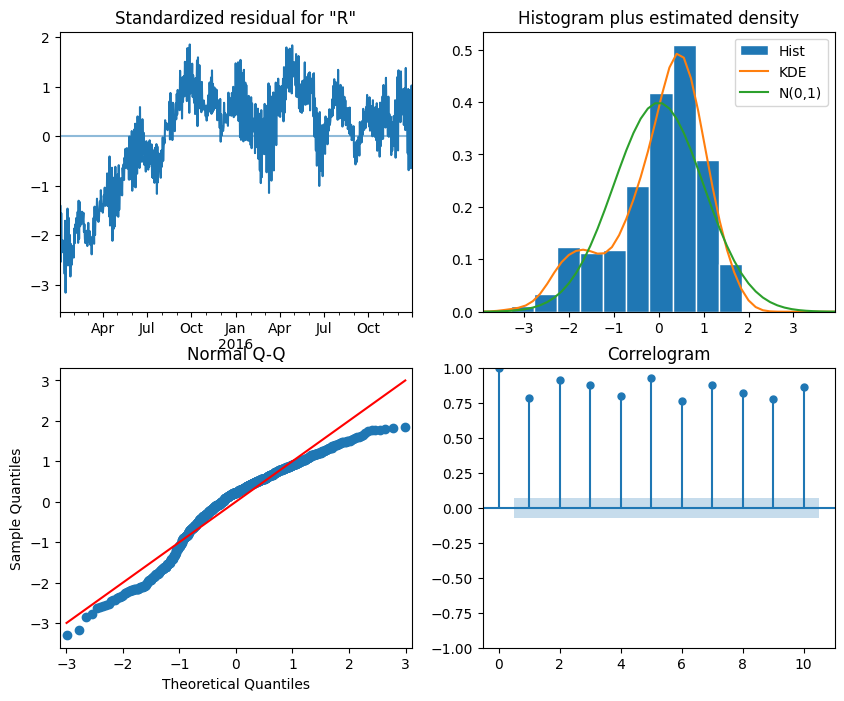

In [31]:
results.plot_diagnostics(figsize = (10,8))
plt.show

In [32]:
#Build forecast 30 days outside of the model
results.forecast(30)

2017-01-01    15.739958
2017-01-02    13.930759
2017-01-03    14.180860
2017-01-04    14.180860
2017-01-05    14.180860
2017-01-06    14.180860
2017-01-07    14.180860
2017-01-08    14.180860
2017-01-09    14.180860
2017-01-10    14.180860
2017-01-11    14.180860
2017-01-12    14.180860
2017-01-13    14.180860
2017-01-14    14.180860
2017-01-15    14.180860
2017-01-16    14.180860
2017-01-17    14.180860
2017-01-18    14.180860
2017-01-19    14.180860
2017-01-20    14.180860
2017-01-21    14.180860
2017-01-22    14.180860
2017-01-23    14.180860
2017-01-24    14.180860
2017-01-25    14.180860
2017-01-26    14.180860
2017-01-27    14.180860
2017-01-28    14.180860
2017-01-29    14.180860
2017-01-30    14.180860
Freq: D, Name: predicted_mean, dtype: float64

In [33]:
p_train = df2.iloc[:-30]
p_test = df2.iloc[-30:]
print(train.shape,test.shape)

(584, 1) (145, 1)


In [34]:
#Prediction for the Final Model
start = len(train)
end = len(test) + 720

prediction = results.predict(start, end, type='levels')

Text(0.5, 1.0, 'Final Model')

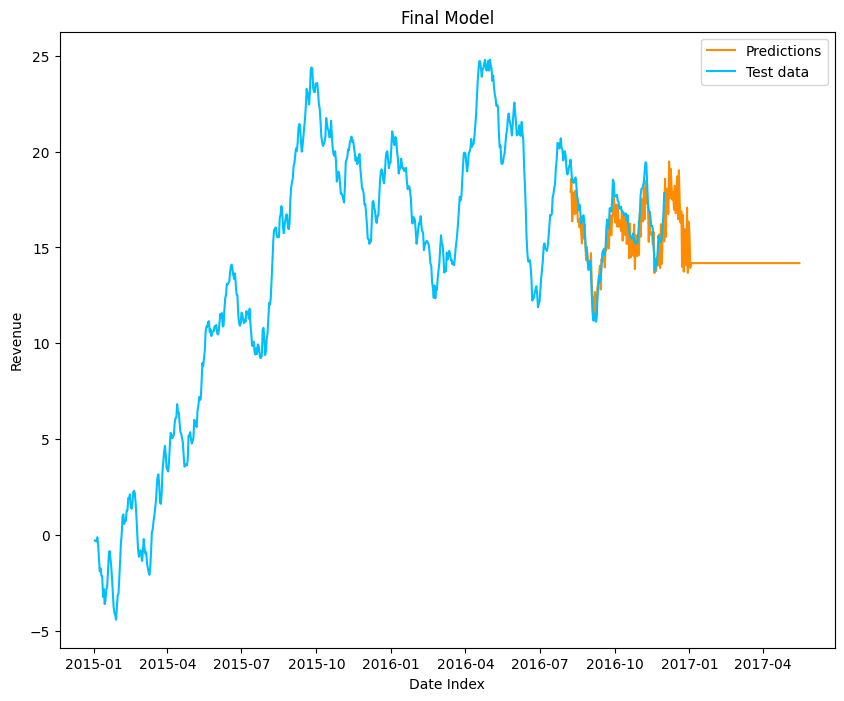

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
pred = plt.plot(prediction, "darkorange", label = 'Predictions')
plt.plot(p_train['Revenue'], "deepskyblue", label = 'Test data')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Final Model'
plt.legend()
plt.title(title)

AttributeError: 'list' object has no attribute 'get_prediction'

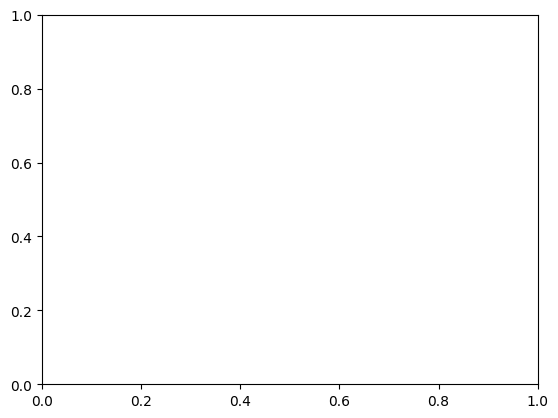

In [38]:
plot_predict(pred)